# Regresión Lineal con TensorFlow para grandes datasets

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'1.3.0'

In [3]:
# Además de TensorFlow, importamos algunas librerías que pueden resultarnos de utilidad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Generamos un buen número de datos aleatorios de los que hacer uso para realizar la regresión:

In [4]:
# Elegimos el número de variables independientes
num_features = 1000000
# Generamos los valores de x 
x_data = np.linspace(0.0, 10.0, num_features)
# Y les metemos algo de ruido
x_data += np.random.uniform(-0.5,0.5,num_features)

In [5]:
x_data

array([  0.48072575,  -0.02424944,  -0.32384839, ...,  10.17069357,
        10.23588842,  10.11950999])

Generamos las variables dependientes:

`y_label = m · x_data + b + ruido`

Elegimos `m = 2.0` y `b = 1.5`

In [6]:
y_label = 2.0 * x_data + 1.5 + np.random.normal(-2, 2, num_features)

In [7]:
# Pandas nos permite ordenar en formato tabular todas nuestras variables para acceder de manera rápida a ellas
my_data = pd.concat([pd.DataFrame(data=x_data,columns=["x_data"]),
                     pd.DataFrame(data=y_label,columns=["y_label"])], 
                    axis = 1)

In [8]:
# Una breve muestra de cómo la variable "my_data" recoge las variables sobre las que se realizará la regresión
my_data.head()

,x_data,y_label
0,0.480726,3.379555
1,-0.024249,0.376482
2,-0.323848,0.755134
3,0.376311,3.218991
4,0.432602,-1.154043


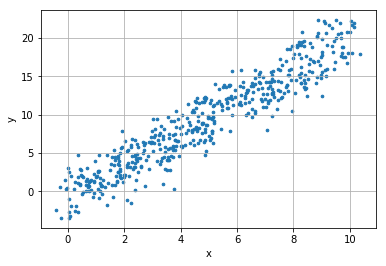

In [9]:
# Elegimos una muestra de 500 pares de datos para su representación. 
sampling = my_data.sample(n = 500)
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Dado el elevado número de variables que estamos manejando, debemos partir nuestro dataset en batches de un determinado tamaño para entrenar nuestro modelo.
Elegiremos un tamaño de batch de 10 puntos al azar cada vez.

In [10]:
batch_size = 10

In [11]:
# Inicializamos con valores aleatorios como variables la pendiente y la intersección 
# de nuestra recta a ajustar a los datos.
misc = np.random.rand(2)

m = tf.Variable(misc[0], dtype = tf.float32, name = 'slope')
b = tf.Variable(misc[1], dtype = tf.float32, name = 'intercept')

In [12]:
x = tf.placeholder(tf.float32, [batch_size], name = 'x')
y = tf.placeholder(tf.float32, [batch_size], name = 'y')

In [13]:
# Se define la operación del ajuste lineal
y_model = m * x + b

La función de pérdida que vamos a usar se puede construir fácilmente con TensorFlow:

In [14]:
# Elegimos como función de coste la RMS.
error = tf.reduce_sum(tf.square(y - y_model), name = 'loss_func')

In [15]:
# Podemos escoger el optimizador que deseemos. En este caso recurrimos a tf.train.GradientDescentOptimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001, name = 'optim')
train = optimizer.minimize(error)

In [16]:
init = tf.global_variables_initializer()

In [17]:
with tf.Session() as sess:
    
    sess.run(init)
    # Elegimos un número de batches 
    num_batches = 10000
    
    for i in range(num_batches):
        
        # Creamos conjuntos de índices aleatorios de tamaño batch_size para muestrear en el dataset
        rand_ind = np.random.randint(num_features, size = batch_size)
        
        # Pasamos las variables en un feed dictionary: sess.run(operation, feed_dict={...})
        # La operación es la dirigida a minimizar el error a través del optimizador elegido
        sess.run(train, feed_dict= {x: x_data[rand_ind], y:y_label[rand_ind]})
        
    # Los resultados de la pendiente y el punto de intersección    
    final_m, final_b = sess.run([m, b])
    
    # sess.graph contiene la definición del grafo. Con esto habilitaremos el Graph Visualizer en tensorboard.
    # Desde un terminal seremos capaces de lanzar tensorboard. Las instrucciones quedan indicadas después de 
    # este notebook.
    file_writer = tf.summary.FileWriter("log/regresion_batches_tensorflow/", sess.graph)

In [18]:
# Los valores estimados para la pendiente "m" y el punto de intersección "b" son respectivamente:
print (final_m, final_b)

1.98998 -0.503472


## Evaluación del ajuste

In [19]:
# Elegimos un conjunto de variables independientes de prueba y obtenemos su predicción 
x_test = np.linspace(-1, 12, 50)
y_test = final_m * x_test + final_b

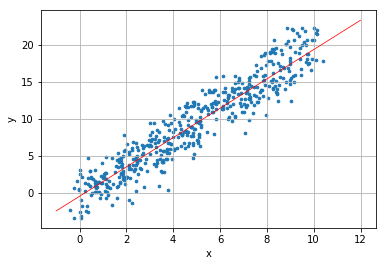

In [20]:
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.plot(x_test, y_test, 'r', linewidth = .75)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

La línea roja estimada por nuestro modelo se ajusta adecuadamente a la nube de puntos. 
El coeficiente de determinación r-squared para nuestro ajuste a toda la nube de puntos:

In [21]:
# Suma de los cuadrados de los residuos:
SS_res = np.sum((y_label - (final_m * x_data + final_b))**2)
# La suma de los cuadrados totales se define como:
SS_tot = np.sum((y_label - np.mean(y_label))**2)

# El coeficiente r**2 se define como:
r_squared = 1 - SS_res/SS_tot

In [22]:
r_squared

0.89381264823729345

## tf.estimator API

En esta parte del notebook se proporciona una introducción al uso de los Estimadores en TensorFlow. Estos estimadores son
una API de TensorFlow que simplifican la programación de algortimos de Machine Learning. 
Los Estimadores encapsulan el entrenamiento, evaluación y predicción.
Además, son capaces de construir el grafo, inicializar variables, crear checkpoints del modelo y guardar summaries para TensorBoard.

In [23]:
feat_cols = [tf.feature_column.numeric_column("x", shape=[1])]

In [24]:
estimator = tf.estimator.LinearRegressor(feature_columns = feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_session_config': None, '_model_dir': '/tmp/tmpt20_mtn9', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None}


### Partición del dataset en conjuntos de entrenamiento y evaluación

In [25]:
# Hacemos uso de la función train_test_split de sklearn
from sklearn.model_selection import train_test_split

In [26]:
# Definimos los datos de entrenamiento y evaluación del modelo. Elegimos una razón 3:1
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_label, test_size=0.25)

In [27]:
print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)

(750000,) (750000,)
(250000,) (250000,)


### Generación de los inputs con los que alimentaremos al estimador

In [28]:
input_func = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=10, num_epochs=None, shuffle=True)

In [29]:
train_input_func = tf.estimator.inputs.numpy_input_fn({"x": x_train}, y_train, batch_size=10, num_epochs=10000, shuffle=False)

In [30]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({"x": x_eval}, y_eval, batch_size=10, num_epochs=10000, shuffle=False)

### Entrenamiento del estimador

In [31]:
estimator.train(input_fn = input_func, steps = 1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpt20_mtn9/model.ckpt.
INFO:tensorflow:step = 1, loss = 955.156
INFO:tensorflow:global_step/sec: 571.998
INFO:tensorflow:step = 101, loss = 40.9235 (0.181 sec)
INFO:tensorflow:global_step/sec: 613.515
INFO:tensorflow:step = 201, loss = 53.7345 (0.164 sec)
INFO:tensorflow:global_step/sec: 504.202
INFO:tensorflow:step = 301, loss = 46.6652 (0.193 sec)
INFO:tensorflow:global_step/sec: 614.667
INFO:tensorflow:step = 401, loss = 20.678 (0.167 sec)
INFO:tensorflow:global_step/sec: 461.453
INFO:tensorflow:step = 501, loss = 28.1145 (0.211 sec)
INFO:tensorflow:global_step/sec: 585.833
INFO:tensorflow:step = 601, loss = 61.9846 (0.170 sec)
INFO:tensorflow:global_step/sec: 626.145
INFO:tensorflow:step = 701, loss = 57.5413 (0.162 sec)
INFO:tensorflow:global_step/sec: 559.851
INFO:tensorflow:step = 801, loss = 64.4317 (0.176 sec)
INFO:tensorflow:global_step/sec: 706.753
INFO:tensorflow:step = 901, loss

In [32]:
train_metrics = estimator.evaluate(input_fn = train_input_func, steps = 1000)

INFO:tensorflow:Starting evaluation at 2018-05-22-10:29:04
INFO:tensorflow:Restoring parameters from /tmp/tmpt20_mtn9/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:Evaluation [23/1000]
INFO:tensorflow:Evaluati

INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorflow:Evaluation [241/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorflow:Evaluation [457/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorflow:Evaluation [672/1000]
INFO:tensorflow:Evaluation [673/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorflow:Evaluation [888/1000]
INFO:tensorf

In [33]:
eval_metrics = estimator.evaluate(input_fn = eval_input_func, steps = 1000)

INFO:tensorflow:Starting evaluation at 2018-05-22-10:29:09
INFO:tensorflow:Restoring parameters from /tmp/tmpt20_mtn9/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:Evaluation [23/1000]
INFO:tensorflow:Evaluati

INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorflow:Evaluation [241/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [431/1000]
INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [646/1000]
INFO:tensorflow:Evaluation [647/1000]
INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [862/1000]
INFO:tensorflow:Evaluation [863/1000]
INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorf

In [34]:
# Las estadísticas del entrenamiento y de la evaluación de nuestro test dataset son:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 4.0622344, 'loss': 40.622345, 'global_step': 1000}
eval metrics: {'average_loss': 4.0833774, 'loss': 40.833775, 'global_step': 1000}


### Obteniendo las predicciones del modelo

In [35]:
# Volvemos a hacer uso de tf.estimator.inputs.numpy_input_fn()
# Intentamos predecir qué valores obtendríamos del modelo si introducimos, 
# por ejemplo, un vector np.linspace(0,10,10)
input_fn_predict = tf.estimator.inputs.numpy_input_fn({"x": np.linspace(0,10,10)}, shuffle=False)

In [36]:
list(estimator.predict(input_fn = input_fn_predict))

INFO:tensorflow:Restoring parameters from /tmp/tmpt20_mtn9/model.ckpt-1000


[{'predictions': array([-0.00858639], dtype=float32)},
 {'predictions': array([ 2.17043519], dtype=float32)},
 {'predictions': array([ 4.34945679], dtype=float32)},
 {'predictions': array([ 6.52847767], dtype=float32)},
 {'predictions': array([ 8.70750046], dtype=float32)},
 {'predictions': array([ 10.88652039], dtype=float32)},
 {'predictions': array([ 13.06554222], dtype=float32)},
 {'predictions': array([ 15.24456406], dtype=float32)},
 {'predictions': array([ 17.42358589], dtype=float32)},
 {'predictions': array([ 19.60260582], dtype=float32)}]

In [37]:
# Para mejor manejabilidad a la hora de realizar cálculs, hacemos un append de las predicciones:
predictions = []
for x in estimator.predict(input_fn = input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Restoring parameters from /tmp/tmpt20_mtn9/model.ckpt-1000


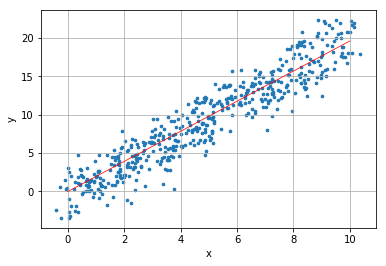

In [38]:
# Volvemos a representar una muestra de nuestros datos para superponer las predicciones anteriormente calculadas.
plt.scatter(sampling["x_data"], sampling["y_label"], s = 7)
plt.plot(np.linspace(0,10,10), predictions, 'r', linewidth = .75)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Con esto hemos conseguido abordar un problema de regresión lineal con un data set extenso de manera satisfactoria haciendo uso de TensorFlow.